# Dynamo with external velocity method

While Dynamo provides its own robust framework for estimating RNA velocity and reconstructing vector fields, it is designed to be an open and interoperable platform. We recognize the rapidly evolving landscape of velocity estimation methods—such as CellDancer, LatentVelo, DeepVelo, and VeloVI—each offering unique advantages for specific datasets or biological contexts.

This tutorial demonstrates how to seamlessly integrate these external velocity methods into the Dynamo workflow. In dynamo, we provided an function named {meth}`dynamo.tl.extvelo` to perform the velocity calculation with Celldancer/latentvelo/deepvelo/velovi.

In [1]:
import dynamo as dyn
dyn.configuration.set_figure_params('dynamo', background='white')
print(f'dynamo version: {dyn.__version__}')

dyn.pl.style(font_path='Arial',show_monitor=True)

%load_ext autoreload
%autoreload 2

dynamo version: 1.4.3rc1
Using already downloaded Arial font from: /tmp/dynamo_arial.ttf
Registered custom font as: Arial


 ███                               ████████        
█████   █████    █████    █████    ███   █████      
   ██████   ██████   ██████   ████████      ████ 
  ___                           ████            ███
 |   \ _  _ _ _  __ _ _ __  ___                 ███
 | |) | || | ' \/ _` | '  \/ _ \█████           ███ 
 |___/ \_, |_||_\__,_|_|_|_\___/█████       ████  
       |__/                        ███   █████     
Tutorial: https://dynamo-release.readthedocs.io/       
                                     █████      



## Preprocessing and Data Loading

First, we load the pancreatic's endocrinogenesis data using {meth}`dynamo.sample_data.pancreatic_endocrinogenesis` and perform standard preprocessing. Whether you are starting from raw counts or a pre-processed h5ad file, ensure that your data contains the necessary spliced and unspliced matrices if required by the external method of your choice.

In [2]:
adata=dyn.sample_data.pancreatic_endocrinogenesis()
adata

|-----> Downloading data to ./data/endocrinogenesis_day15.h5ad
|-----> File ./data/endocrinogenesis_day15.h5ad already exists.


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [3]:
preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True)
preprocessor.preprocess_adata(adata, recipe='monocle')

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 0 outlier cells
|-----------> filtered out 21736 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [12.0585s]
|-----> [Cell Cycle Scores Estimation] completed [0.3186s]
|-----> [Preprocessor-monocle] completed [3.9592s]

╭─ SUMMARY: Preprocessor.preprocess_adata ───────────────────────────╮
│  Duration: 3.9606s                                                 │
│  Shape:    3,696 x 27,998 (Unchanged)                              │
│                                                                    │
│  CHANGES DETECTED                                                  │
│  ────────────────                                                  │
│  ● OBS    │ ✚ Size_Factor (float)                                  │
│           │ ✚ cell_cycle_phase (category)                          │
│           │ 

Further, we need the first and second order moments (means and uncentered variances) computed among nearest neighbors in PCA space, summarized in {meth}`dynamo.tl.moments`. First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.

In [4]:
dyn.tl.moments(adata, n_neighbors=30)

|-----> calculating first/second moments...
|-----> [moments calculation] completed [18.4611s]

╭─ SUMMARY: moments ─────────────────────────────────────────────────╮
│  Duration: 18.4695s                                                │
│  Shape:    3,696 x 27,998 (Unchanged)                              │
│                                                                    │
│  CHANGES DETECTED                                                  │
│  ────────────────                                                  │
│  ● OBSP   │ ✚ moments_con (sparse matrix, 3696x3696)               │
│                                                                    │
│  ● LAYERS │ ✚ M_s (sparse matrix, 3696x27998)                      │
│           │ ✚ M_ss (sparse matrix, 3696x27998)                     │
│           │ ✚ M_u (sparse matrix, 3696x27998)                      │
│           │ ✚ M_us (sparse matrix, 3696x27998)                     │
│           │ ✚ M_uu (sparse matrix, 3696x27998)    

In [5]:
adata=adata[:,adata.var['use_for_pca']]
adata

View of AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'score', 'log_cv', 'frac', 'use_for_pca', 'ntr'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'cell_phase_order', 'cell_phase_genes', 'history_log'
    obsm: 'X_pca', 'X_umap', 'cell_cycle_scores'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss'
    obsp: 'distances', 'connectivities', 'moments_con'

## Importing External Velocity Results

If you wish to import RNA velocity results calculated by other tools into Dynamo for downstream analysis (such as vector field reconstruction or manifold projection), you must manually add the following variables and initialize the dynamics configuration:

```python
# 1. Import the velocity matrix (e.g., for Spliced RNA)
# Ensure dimensions match adata.shape
adata.layers["velocity_S"] = <your_velocity_matrix>

# 2. Mark genes used for dynamics
# Type: Boolean mask
adata.var['use_for_dynamics'] = <your_velocity_genes_mask>

# 3. Mark high-confidence genes for transition matrix calculation
# Type: Boolean mask, typically a subset of 'use_for_dynamics'
adata.var['use_for_transition'] = <your_high_confidence_genes_mask>

# 4. Initialize Dynamics Metadata (Critical Step)
# Omitting this may cause downstream tools to fail in identifying the experiment type
adata.uns["dynamics"] = {
    "t": None,
    "group": None,
    "X_data": None,
    "X_fit_data": None,
    "asspt_mRNA": "ss",
    "experiment_type": "conventional", # Set to 'kin' for kinetic/labeling experiments
    "normalized": True,
    "model": "stochastic",
    "est_method": "auto",
    "has_splicing": True,
    "has_labeling": False,
    "splicing_labeling": False,
    "has_protein": False,
    "use_smoothed": True,
    "NTR_vel": False,
    "log_unnormalized": True,
    "fraction_for_deg": False
}
```

If you're unsure which genes your method utilizes when calculating velocity, you can set them all as highly variable genes, i.e., `adata.var['use_for_dynamics']=adata.var['highly_variable']` and `adata.var['use_for_transition']=adata.var['highly_variable']`.

#### Key Variable Definitions

To ensure analysis accuracy, please construct the two `var` variables above based on the following criteria:

**1. `use_for_dynamics` (Used for Kinetic Modeling)**

*   **Definition**: Marks genes suitable for kinetic parameter estimation.
*   **Origin**: Typically generated during the {meth}`dynamo.tl.dynamics()` run.
*   **Selection Criteria**:
    *   Genes that have passed pre-processing quality control (e.g., highly variable genes).
    *   Genes where the data quality is deemed sufficient by the model to attempt parameter fitting (e.g., degradation rate $\gamma$, splicing rate $\beta$) during kinetic inference.
    *   If `sanity_check` is enabled in the `dynamics` function, this may specifically refer to genes that passed the model's basic hypothesis tests.
*   **Usage**: Indicates to Dynamo which genes have calculated kinetic parameters, enabling their use in subsequent analyses (e.g., phase portrait plotting, parameter inspection).

**2. `use_for_transition` (Used for State Transition/Velocity Projection)**

*   **Definition**: Marks high-confidence genes used to calculate the cell-to-cell transition probability matrix.
*   **Origin**: Typically generated during the {meth}`dynamo.tl.cell_velocities()` run via the `set_transition_genes` function.
*   **Selection Criteria**:
    *   Criteria are generally stricter than those for `use_for_dynamics`.
    *   This set is usually a **subset** of `use_for_dynamics`.
    *   Genes must exhibit high model goodness-of-fit (e.g., $R^2$ above a certain threshold, such as `min_r2`).
    *   Kinetic parameters must be significant (e.g., $\gamma$ or $\alpha$ greater than a minimal value).
*   **Usage**:
    *   **Calculating Velocity Vectors**: Only signals from these high-quality genes are used when projecting RNA velocity onto reduced-dimensional spaces (e.g., UMAP, PCA).
    *   **Trajectory Inference**: Relies on these genes to determine the future direction of cells when constructing the cell state transition graph.
    *   Using high-quality genes reduces noise, resulting in more accurate velocity fields and manifold learning.


## Running External Velocity Methods

In this section, we apply external tools to estimate RNA velocity. You can choose the method that best suits your hypothesis in {meth}`dynamo.tl.extvelo`.



### Option A: Using VeloVI

VeloVI uses a deep generative model to estimate velocity. After training the model, we extract the velocity vectors and store them in the AnnData object.

In [6]:
adata=adata.copy()
adata.layers['Ms']=adata.layers['M_s'].toarray()
adata.layers['Mu']=adata.layers['M_u'].toarray()

In [7]:
adata_velovi=dyn.tl.extvelo(
    adata,
    method='velovi',
    celltype_key='clusters',
    basis= "X_umap",
    Ms_key= "Ms",
    Mu_key= "Mu",
)

/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2258.396. Signaling Trainer to stop.


In [8]:
adata_velovi.write('data/pancreas_velovi.h5ad')

### Option B: Using CellDancer

CellDancer estimates velocity for each cell using a dynamical model that accounts for transcriptional kinetics.

In [ ]:
celldancer_df,adata_celldancer=dyn.tl.extvelo(
    adata,
    method='celldancer',
    basis= "X_umap",
    Ms_key= "M_s",
    Mu_key= "M_u",
    permutation_ratio=0.5, 
    model_dir_path='model',
    n_jobs=1,        
    device='cuda',
)


reating DataFrame: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]       

Using /scratch/users/steorra/analysis/25_dynamo_protocol/cellDancer_velocity_2025-11-19 18-23-02 as the output path.
Processing 2000 genes in 2000 batches with n_jobs=1


Processing genes:   1%|          | 11/2000 [00:18<54:19,  1.64s/gene] 

In [ ]:
adata_celldancer.write('data/pancreas_celldancer.h5ad')

### Option C: Using DeepVelo or LatentVelo

Similarly, outputs from DeepVelo or LatentVelo can be assigned to the `adata.layers['velocity_S']`

In [6]:
latent_adata,adata_latentvelo=dyn.tl.extvelo(
    adata,
    method='latentvelo',
    celltype_key='clusters',
    basis= "X_umap",
    Ms_key= "M_s",
    Mu_key= "M_u",
    batch_size = 100, learning_rate=1e-2,
    epochs=50, param_name_key='temp/latentvelo_params',
    grad_clip=100,
    latentvelo_VAE_kwargs={
        'latent_dim':50,
        'zr_dim':2,
        'h_dim':2,
    }
)

Using device: cuda
Extracted 2000 highly variable genes.
Choosing top 2000 genes
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Warning, folder already exists. This may overwrite a previous fit.
992 velocity genes used


LatentVelo(ANVI):   0%|          | 0/50 [00:00<?, ?epoch/s]

Loading best model at 42 epochs.


In [7]:
adata_latentvelo.write('data/pancreas_latentvelo.h5ad')

In [10]:
adata_deepvelo=dyn.tl.extvelo(
    adata,
    method='deepvelo',
    celltype_key='clusters',
    basis= "X_umap",
    Ms_key= "M_s",
    Mu_key= "M_u",
)

/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/dgl/backend/backend.py:1838: DeprecationWarning: invalid escape sequence '\P'
  """Segment reduction operator.
/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/dynamo/external/deepvelo/model/layers.py:18: DeprecationWarning: invalid escape sequence '\T'
  """


building graph


INFO:train:Beginning training of DeepVelo_Base ...


velo data shape: torch.Size([3696, 2000])


Training:   0%|          | 0/100 [00:00<?, ?it/s]

confidence mse shape: (3696, 2000)
confidence mse stats: max 20935.3828125, min 0.0, mean 1.2487114667892456, std 51.508358001708984
confidence corr shape: (2000,)
confidence corr stats: max 0.8349388837814331, min -0.21244624257087708, mean 0.3925401568412781, std 0.13429151475429535
velo_mat shape: (3696, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [11]:
adata_deepvelo.write('data/pancreas_deepvelo.h5ad')

## Projecting Velocity to Embeddings

To visualize the flow on a UMAP or PCA plot, we project the high-dimensional velocity vectors onto the low-dimensional manifold using Dynamo's built-in projection tools using {meth}`dynamo.tl.cell_velocities`.

In [12]:
adata=dyn.read('data/pancreas_celldancer.h5ad')

In [13]:
dyn.tl.cell_velocities(
    adata, method='pearson', 
    other_kernels_dict={'transform': 'sqrt'}
)
dyn.tl.cell_velocities(adata, basis="pca")

Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] completed [0.4457s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected

╭─ SUMMARY: cell_velocities ─────────────────────────────────────────╮
│  Duration: 1.3656s                                                 │
│  Shape:    3,696 x 27,998 (Unchanged)                              │
│                                                                    │
│  CHANGES DETECTED                                                  │
│  ────────────────                                                  │
╰────────────────────────────────────────────────────────────────────╯


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'counts_Size_Factor', 'initial_counts_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition'
    uns: 'PCs', 'cell_phase_genes', 'cell_phase_order', 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'grid_velocity_umap', 'neighbors', 'pca', 'pca_mean', 'pp', 'velocyto_SVR', 'history_log'
    obsm: 'X_pca', 'X_umap', 'cell_cycle_scores', 'velocity_pca', 'velocity_umap'
    layers: 'M_s', 'M_ss', 'M_u', 'M_us', 'M_uu', 'X_counts', 'X_splic

In [14]:
pancreas_cluster_cmap = {
    'Ductal': '#3361A5',
    'Ngn3 low EP': '#248AF3',
    'Ngn3 high EP': '#14B3FF',
    'Pre-endocrine': '#88CEEF',
    'Alpha': '#ff4800',
    'Beta': '#B81136',
    'Delta': 'green',
    'Epsilon': '#03B3B0'
}

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/dynamo/plot/scatters.py:2691: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  labels = np.asarray(_color) if is_categorical_dtype(_color) else _color


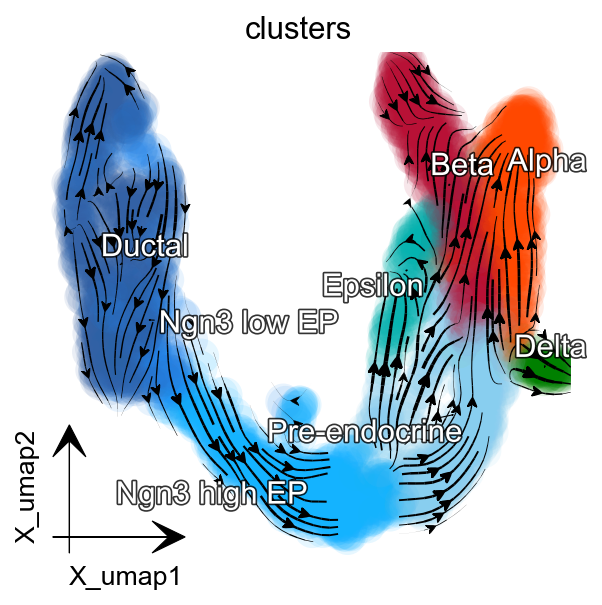

In [16]:
dyn.pl.streamline_plot(
    adata, color=['clusters'], 
    basis='umap', show_legend='on data', 
    s_kwargs_dict={'adjust_legend':True},
    show_arrowed_spines=False,
    color_key = pancreas_cluster_cmap, 
    figsize=(4,4),
)

## Learning the Continuous Vector Field

This is a crucial step where Dynamo adds significant value to the external output. By learning a continuous vector field function $f(x)$ from the discrete velocity samples provided by the external method, Dynamo allows for analytical calculations of system dynamics.

In [17]:
dyn.vf.VectorField(adata, basis='pca', M=500)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [SparseVFC] completed [13.5303s]
|-----> [VectorField] completed [13.6190s]

╭─ SUMMARY: VectorField ─────────────────────────────────────────────╮
│  Duration: 13.6215s                                                │
│  Shape:    3,696 x 27,998 (Unchanged)                              │
│                                                                    │
│  CHANGES DETECTED                                                  │
│  ────────────────                                                  │
│  ● OBS    │ ✚ control_point_pca (bool)                             │
│           │ ✚ i

|-----> Vector field for umap is not constructed. Constructing it now ...
|-----------> `basis` and `fps_basis` are all umap. Will also map topography ...
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [SparseVFC] completed [34.9347s]
|-----> Mapping topography...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [VectorField] completed [45.6864s]

╭─ SUMMARY: VectorField ─────────────────────────────────────────────╮
│  Duration: 45.6885s                                                │
│  Shape:    3

/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/dynamo/plot/scatters.py:2691: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  labels = np.asarray(_color) if is_categorical_dtype(_color) else _color


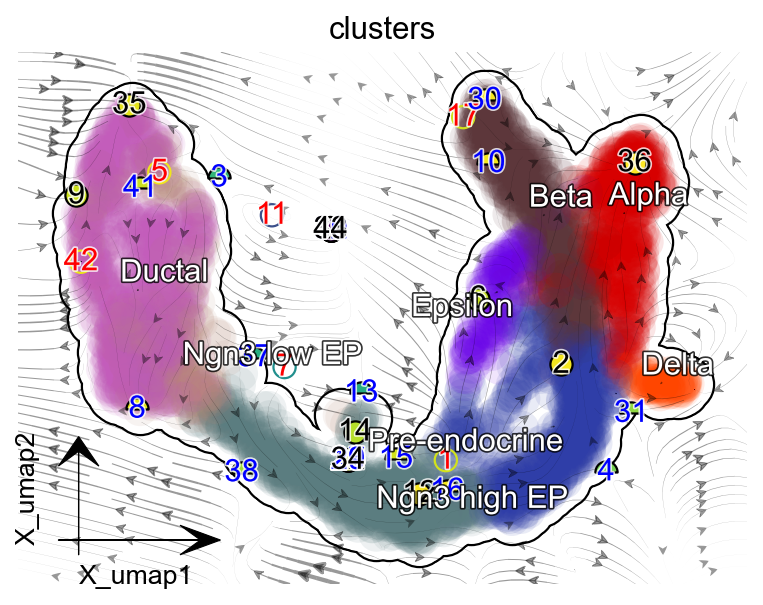

In [18]:
dyn.pl.topography(
    adata, basis='umap', background='white', 
    color=['clusters'], 
    streamline_color='black', 
    s_kwargs_dict={'adjust_legend':True,'dpi':80},
    show_legend='on data', frontier=True,
    figsize=(5,4),markersize=100,s=100,
)

## Downstream Analysis

You can follow our [VectorField analysis chapter](https://dynamo-release.readthedocs.io/en/latest/tutorials/index_vector_pre.html), here we show silico perturbation predictions as an example.

In [19]:
gene = "Gcg"
dyn.pd.perturbation(adata, gene, [-100], emb_basis="umap")

|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....



alculating Jacobian for each cell: 100%|██████████| 3696/3696 [00:00<00:00, 191082.58it/s]

|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] completed [0.4462s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector

╭─ SUMMARY: perturbation ────────────────────────────────────────────╮
│  Duration: 7.0324s                                                 │
│  Shape:    3,696 x 27,998 (Unchanged)                              │
│                                                                    │
│  CHANGES DETECTED                                                  │
│  ────────────────                                                  │
│  ● OBS    │ ✚ jacobian_det_pca (float)                             │
│                                                                    │
│  ● UNS    │ ✚ grid_velocity_umap_perturbation           

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap_perturbation


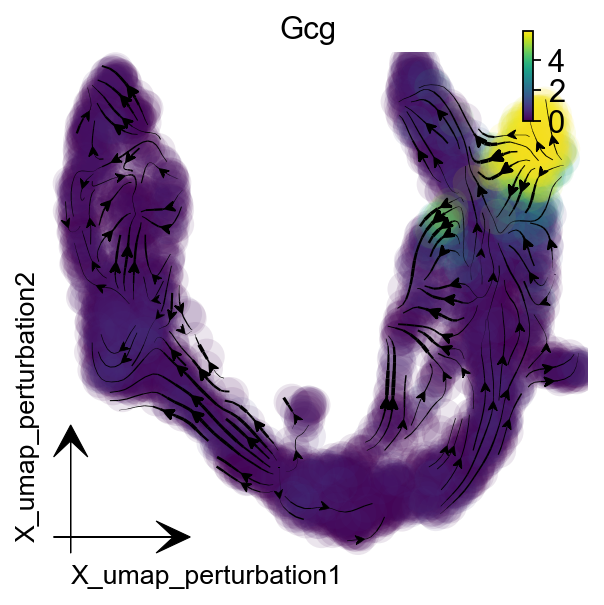

In [20]:
dyn.pl.streamline_plot(
    adata, color=[gene], 
    basis="umap_perturbation",figsize=(4,4),
    s_kwargs_dict={'adjust_legend':True,'dpi':80}
)